# 決定木によるFX予想

決定木は特徴量を分析して、特徴量の値に応じてターゲットを分岐して予測。  
どの特徴量で分岐をするのか？分岐するときの値は？などの細かい部分をアルゴリズムで計算を行う

【メリット】
- 仕組みが非常に簡単で理解しやすい
- 特徴量の正規化が不要
- 計算コストが低い
- 分類と回帰が行える
- 予測の説明が出来る！（超重要）

【デメリット】
- 気をつけないと過学習する
- 単純な仕組みなので精度はさほど高くない

メモ  
Homebrewをインストールしたらgraphvizのgraph = graphviz.Source(dot_data)が使えるようになった

参考文献(ほぼまるパクリ)  
http://www.algo-fx-blog.com/decision-tree-classification-fx/  

## STEP1 ライブラリとデータの読み込み

In [29]:
# データ処理のライブラリ
import pandas as pd
import numpy as np 
 
# データ可視化のライブラリ
import matplotlib.pyplot as plt
 
# 機械学習ライブラリ
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Enter your code here
from sklearn.tree import DecisionTreeRegressor#regressor 回帰問題

# graphvizのインポート
import graphviz
# バージョンの確認
print(graphviz.__version__)

# モデルの木構造の視覚化に必要なパッケージ
from sklearn import tree
import pydotplus as pdp

0.13.2


In [2]:
# CSVファイルの読み込み
df = pd.read_csv('usd_jpy_api.csv')

In [3]:
df.head()

,time,close,open,high,low,volume
0,2016/08/19 06:00:00,100.256,99.919,100.471,99.887,30965
1,2016/08/22 06:00:00,100.335,100.832,100.944,100.221,32920
2,2016/08/23 06:00:00,100.253,100.339,100.405,99.950,26069
3,2016/08/24 06:00:00,100.460,100.270,100.619,100.104,22340
4,2016/08/25 06:00:00,100.546,100.464,100.627,100.314,17224


In [4]:
df.tail()

,time,close,open,high,low,volume
495,2018/07/17 06:00:00,112.908,112.320,112.933,112.231,19645
496,2018/07/18 06:00:00,112.866,112.914,113.144,112.723,17432
497,2018/07/19 06:00:00,112.501,112.887,113.187,112.072,26697
498,2018/07/20 06:00:00,111.474,112.504,112.631,111.401,33445
499,2018/07/23 06:00:00,111.164,111.420,111.523,110.760,16040


In [5]:
#df.index.name = 'Date'# 必須
df = df.rename(columns={'time': 'Time','close': 'Close', 'open': 'Open', 'high': 'High', 'low': 'Low', 'volume': 'Volume'})# 必須
df.head()

,Time,Close,Open,High,Low,Volume
0,2016/08/19 06:00:00,100.256,99.919,100.471,99.887,30965
1,2016/08/22 06:00:00,100.335,100.832,100.944,100.221,32920
2,2016/08/23 06:00:00,100.253,100.339,100.405,99.950,26069
3,2016/08/24 06:00:00,100.460,100.270,100.619,100.104,22340
4,2016/08/25 06:00:00,100.546,100.464,100.627,100.314,17224


In [6]:
df.shape

(500, 6)

## STEP2 データの前処理

今回は当日の終値、始値、高値、安値、取引高を特徴量として、翌日の終値が上昇するか下降するかを予測。  
<span style="color: red; ">詰まるところ、ここの設定が**要**？</span>

In [7]:
# 翌日終値 - 当日終値で差分を計算
df['close+1'] = df['Close'].shift(-1)
df['diff'] = df['close+1'] - df['Close']
df = df[:-1]
 
# 最後の5行を確認
df.tail()

,Time,Close,Open,High,Low,Volume,close+1,diff
494,2018/07/16 06:00:00,112.320,112.252,112.570,112.235,12518,112.908,0.588
495,2018/07/17 06:00:00,112.908,112.320,112.933,112.231,19645,112.866,-0.042
496,2018/07/18 06:00:00,112.866,112.914,113.144,112.723,17432,112.501,-0.365
497,2018/07/19 06:00:00,112.501,112.887,113.187,112.072,26697,111.474,-1.027
498,2018/07/20 06:00:00,111.474,112.504,112.631,111.401,33445,111.164,-0.310


データ全体で上昇した日と下降した日の割合を確認。

In [8]:
# 上昇と下降のデータ割合を確認
m = len(df['Close'])
print(len(df[(df['diff'] > 0)]) / m * 100)
print(len(df[(df['diff'] < 0)]) / m * 100)

50.70140280561122
49.298597194388776


次は上昇した日は「1」、下降した日は「0」となるようにデータを処理。

In [9]:
# 上昇したら「1」、下降したら「0」へデータを変換
mask1 = df['diff'] > 0
mask2 = df['diff'] < 0
column_name = 'diff'
df.loc[mask1, column_name] = 1
df.loc[mask2, column_name] = 0

# 最初の5行を表示
df.head()

,Time,Close,Open,High,Low,Volume,close+1,diff
0,2016/08/19 06:00:00,100.256,99.919,100.471,99.887,30965,100.335,1.0
1,2016/08/22 06:00:00,100.335,100.832,100.944,100.221,32920,100.253,0.0
2,2016/08/23 06:00:00,100.253,100.339,100.405,99.950,26069,100.460,1.0
3,2016/08/24 06:00:00,100.460,100.270,100.619,100.104,22340,100.546,1.0
4,2016/08/25 06:00:00,100.546,100.464,100.627,100.314,17224,101.876,1.0


In [10]:
# カラム名をtagertへ変換
df.rename(columns={"diff" : "Target"}, inplace=True)
 
# 不要なカラムを削除
del df['Time']
del df['close+1']
 
# カラムの並び替え
df = df[['Target', 'Close', 'Open', 'High', 'Low', 'Volume']]
 
# 最初の5行を出力
df.head()

,Target,Close,Open,High,Low,Volume
0,1.0,100.256,99.919,100.471,99.887,30965
1,0.0,100.335,100.832,100.944,100.221,32920
2,1.0,100.253,100.339,100.405,99.950,26069
3,1.0,100.460,100.270,100.619,100.104,22340
4,1.0,100.546,100.464,100.627,100.314,17224


In [11]:
target_col = 'Target'
feature_cols =["Close","Open","High","Low","Volume"]

In [12]:
#特徴量
df[feature_cols].head()

,Close,Open,High,Low,Volume
0,100.256,99.919,100.471,99.887,30965
1,100.335,100.832,100.944,100.221,32920
2,100.253,100.339,100.405,99.950,26069
3,100.460,100.270,100.619,100.104,22340
4,100.546,100.464,100.627,100.314,17224


In [13]:
#目的変数
df[target_col].head()

0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: Target, dtype: float64

In [14]:
y = np.array(df[target_col])
X = np.array(df[feature_cols])

In [15]:
X

array([[  100.256,    99.919,   100.471,    99.887, 30965.   ],
       [  100.335,   100.832,   100.944,   100.221, 32920.   ],
       [  100.253,   100.339,   100.405,    99.95 , 26069.   ],
       ...,
       [  112.866,   112.914,   113.144,   112.723, 17432.   ],
       [  112.501,   112.887,   113.187,   112.072, 26697.   ],
       [  111.474,   112.504,   112.631,   111.401, 33445.   ]])

In [16]:
y

array([1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 1., 0., 0.

今回は８割りを使って学習させて残りの２割で検証

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1234)

## STEP3 決定技モデルの訓練

In [18]:
clf_2 = DecisionTreeClassifier(max_depth=2)
clf_2 = clf_2.fit(X_train, y_train)

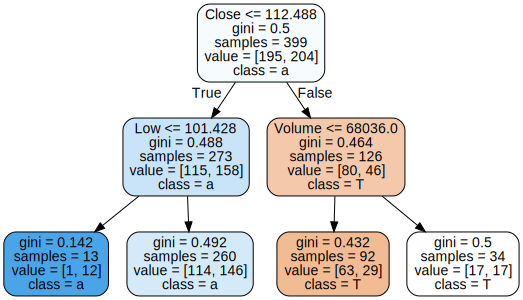

In [19]:
# 決定木の可視化
dot_data = tree.export_graphviz(clf_2, out_file=None, 
                         feature_names=df.columns[1:6],  
                         class_names=df.columns[0],
                         rounded = True, 
                         filled=True
                         )  
graph = graphviz.Source(dot_data)  
graph


In [20]:
# テストデータで予測
pred_test_2 = clf_2.predict(X_test)
 
# テストデータの予測結果（混同行列）
matrix = confusion_matrix(y_test,pred_test_2)
matrix

array([[16, 35],
       [15, 34]])

In [21]:
# ランダムフォレスト テストデータ 正解率
accuracy_score(y_test,pred_test_2)

0.5

In [22]:
# 20層の決定木モデルの訓練
clf_20 = DecisionTreeClassifier(max_depth=20)
clf_20 = clf_20.fit(X_train, y_train)


In [23]:
# テストデータで予測
pred_test_20 = clf_20.predict(X_test)
 
# テストデータの予測結果（混同行列）
matrix = confusion_matrix(y_test,pred_test_20)
matrix
 

array([[24, 27],
       [26, 23]])

In [24]:
# ランダムフォレスト テストデータ 正解率
accuracy_score(y_test,pred_test_20)

0.47

まさかの50％以下

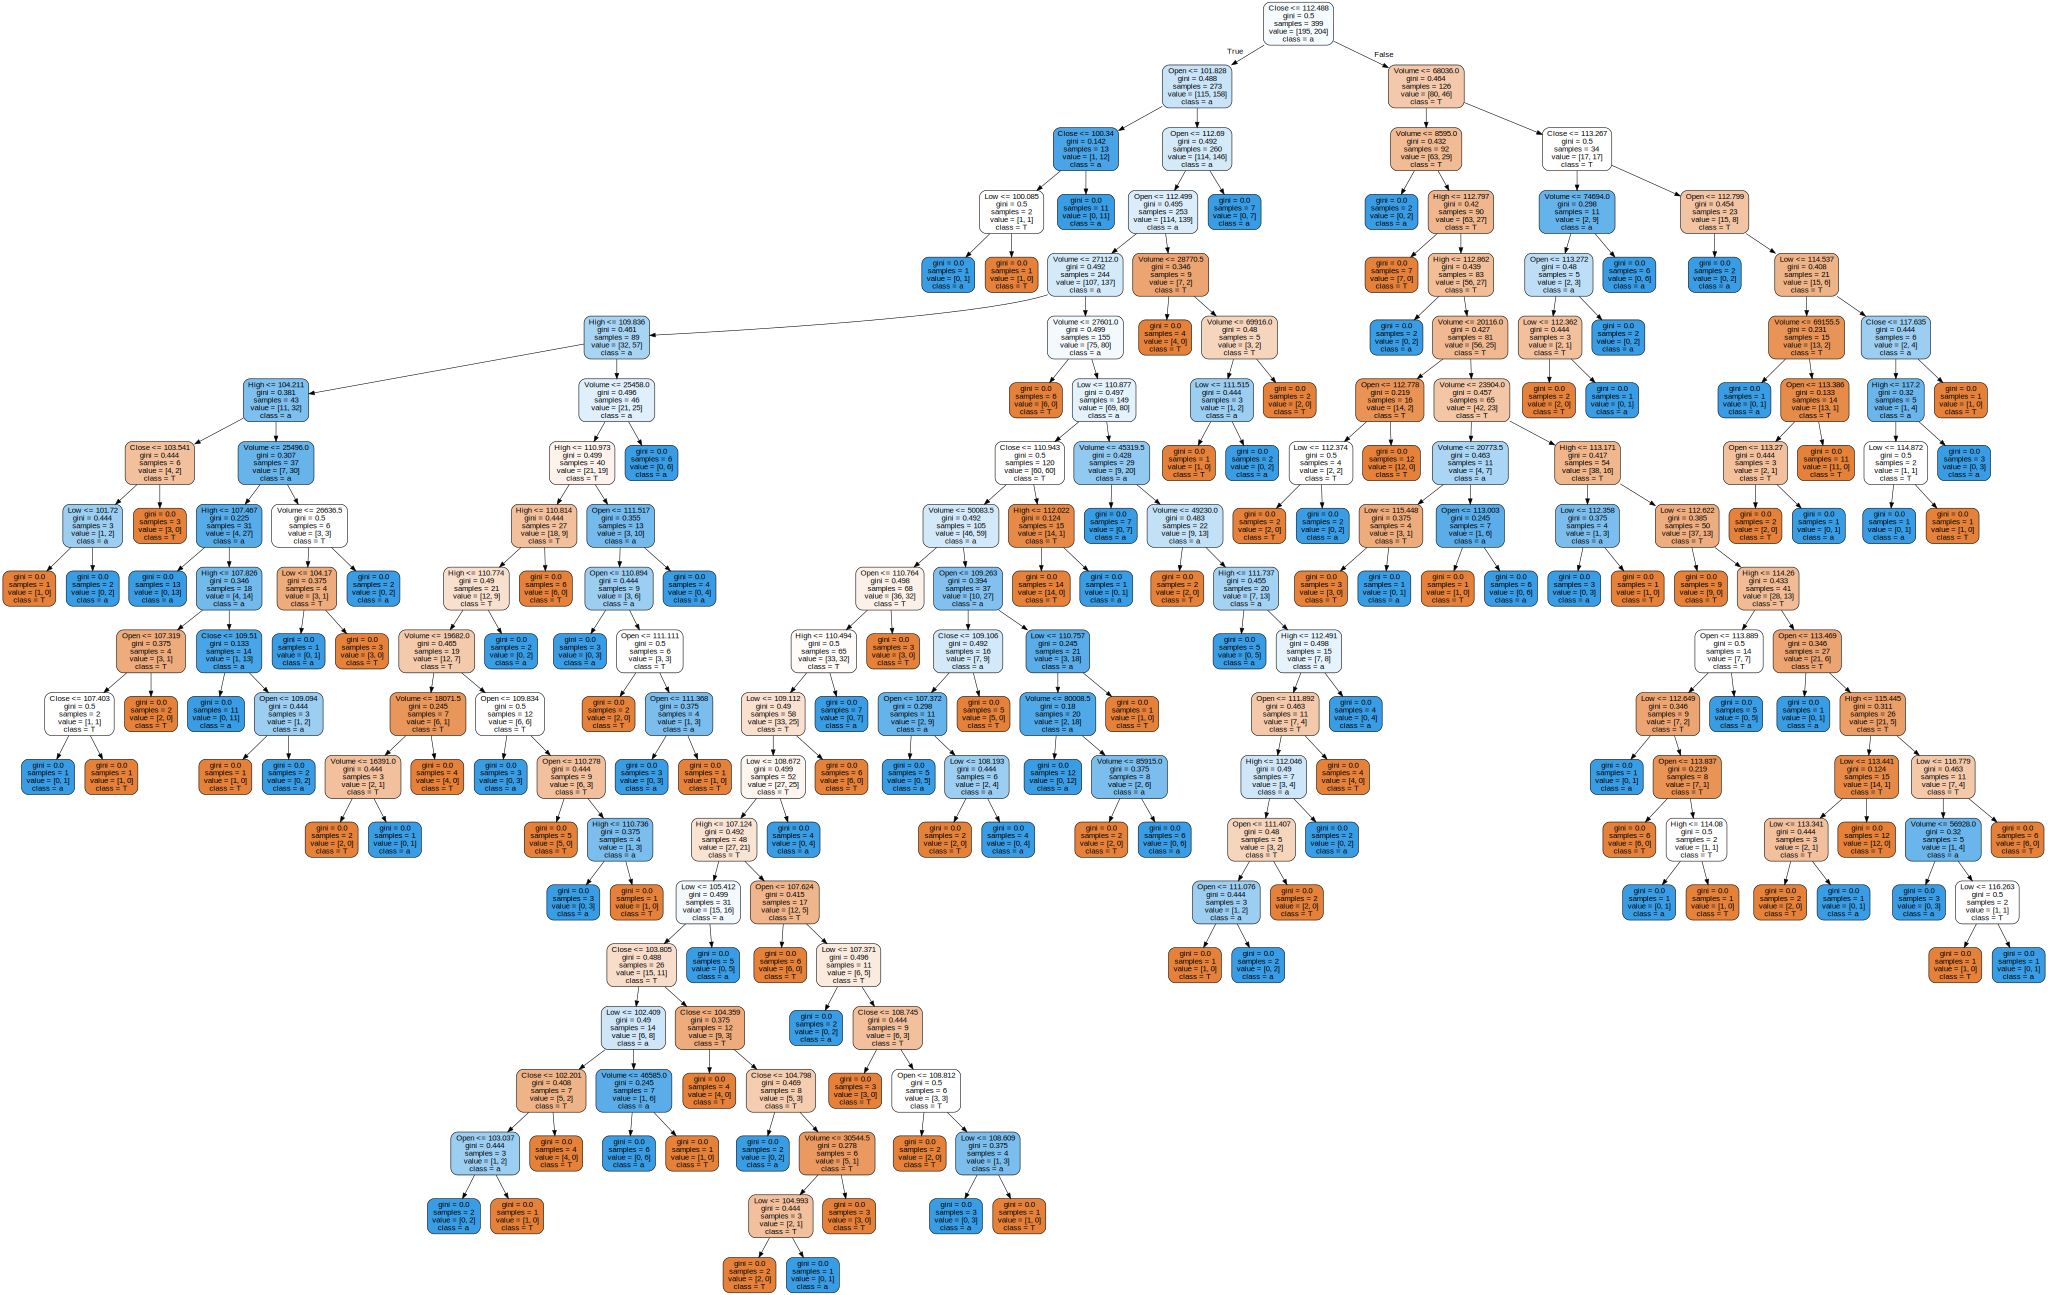

In [27]:
# 決定木の可視化
dot_data = tree.export_graphviz(clf_20, out_file=None, 
                         feature_names=df.columns[1:6],  
                         class_names=df.columns[0],
                         rounded = True, 
                         filled=True
                         )  
graph = graphviz.Source(dot_data)  
graph

In [30]:
graph2 = pdp.graph_from_dot_data(dot_data)
graph2.write_png("20trees.png")

True